In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [99]:
data = pd.read_csv("executions/orders.csv")
data

,id,order_id,trader,event,kind,side,price,qty,instrument,sequence,time,execution_time,status
0,94a4821a-8e9c-4e0f-a69c-836c0e013007,d637cd2a-1c82-49b5-bda3-e3f26d54c76f,89800,New,Limit,Sell,101.12,4910.0,AAPL,0,2022-10-12T19:54:43.121907400Z,23900,Placed
1,c56780fa-5aa8-4827-80b4-c108654306af,973777e4-0443-4342-8ed1-3f43fa392820,26945,New,Limit,Sell,100.92,3464.0,AAPL,1,2022-10-12T19:54:43.121934Z,13700,Placed
2,ce937c19-d0d5-429c-8062-ae96a873e6e7,f699a708-ff8c-4b82-80bd-7b3799152916,77784,New,Limit,Sell,101.70,493.0,AAPL,2,2022-10-12T19:54:43.121937400Z,9400,Placed
3,5bc53ed4-ae90-4525-ac3d-26bef3e074c0,fb7493d7-a380-4170-bd6e-53126f3f681d,95810,New,Market,Sell,100.00,543.0,AAPL,3,2022-10-12T19:54:43.121940800Z,300,Unfilled
4,c06b37ba-5e3d-4f34-aa3f-0107721c0bae,be43bbff-8e10-42ba-9a34-f5dacfed4570,75394,New,Limit,Buy,98.81,7930.0,AAPL,4,2022-10-12T19:54:43.121959900Z,9800,Placed
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,7f5f02ce-3718-4740-841c-b7f596fe8254,2c7da803-73c5-486f-a351-bf844887d34e,11042,New,Market,Buy,100.00,766.0,AAPL,999995,2022-10-12T19:54:52.715112500Z,500,Filled
999996,6a7b3700-a569-4141-9537-76db813576dd,0c8f0689-989a-4908-a784-ed8a3e33f36d,54773,New,Limit,Sell,100.32,8697.0,AAPL,999996,2022-10-12T19:54:52.715115Z,500,Placed
999997,972a1182-2354-4997-8e79-e636d88e023d,dfb1a223-4a02-4982-baa1-443b4ab4f86d,2223,New,Market,Buy,100.00,9338.0,AAPL,999997,2022-10-12T19:54:52.715130Z,600,Filled
999998,d92b9d53-0f18-4f87-9516-56ca91be162f,29e458ac-0ef3-4ed6-977b-29f034383dde,72927,New,Limit,Buy,98.60,4903.0,AAPL,999998,2022-10-12T19:54:52.715132500Z,600,Placed


# Equilibrium mid market price

In [396]:
def exp_decay(start, length, half_life):
    return start * np.exp(-np.log(2)/half_life) ** length

print(exp_decay(10, 1, 1))
print(exp_decay(10, 2, 1))

5.0
2.5


In [397]:
price = [round(i, 1) for i in np.arange(7, 12.1, 0.1)]
bids = list(np.zeros(len(price)))
asks = list(np.zeros(len(price)))

for i, (p, b, a) in enumerate(zip(price, bids, asks)):
    if p == 7: bids[i] = 10000
    if p == 8: bids[i] = 3000
    if p == 9: bids[i] = 4500
    if p == 10: asks[i] = 1000
    if p == 11: asks[i] = 10000
    if p == 12: asks[i] = 2500

d = {
    "price" : price,
    "bids" : bids, 
    "asks" : asks,
}

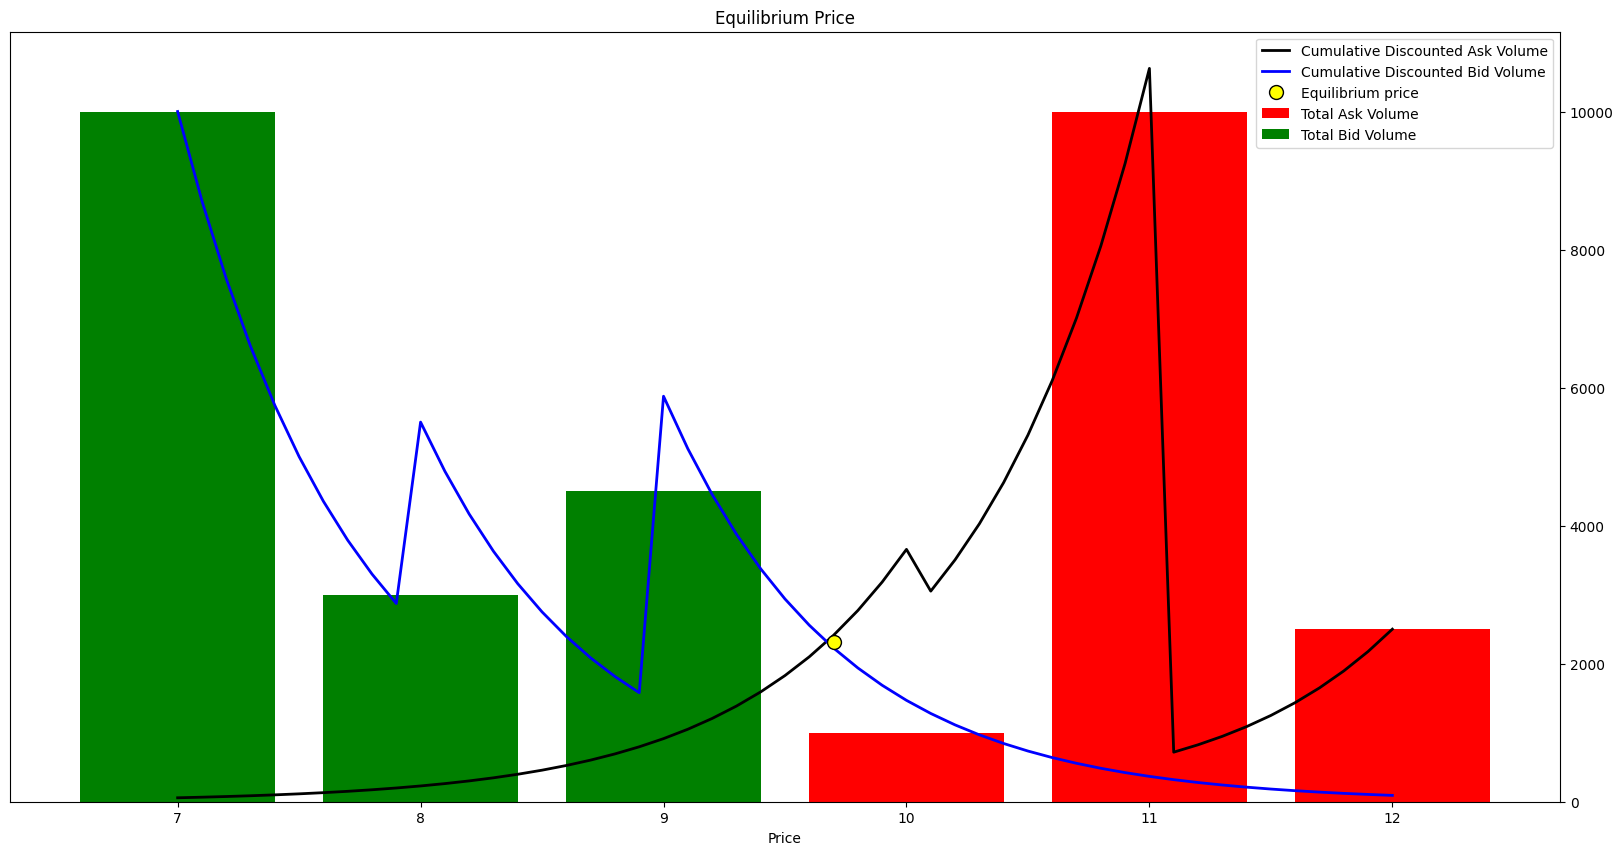

In [399]:
ob = pd.DataFrame(data = d)
delta = 0.1
half_life = 0.5

ob["bids.exp_decay"] = np.nan
ob["asks.exp_decay"] = 2500

for i, row in ob.iterrows():
    if i == 0:
        ob["bids.exp_decay"].iloc[i] = ob["bids"].iloc[i]
    else:
        ob["bids.exp_decay"].iloc[i] = ob["bids"].iloc[i] + exp_decay(ob["bids.exp_decay"].iloc[i-1], delta, half_life)


for i, row in ob[::-1].iterrows():
    if i == len(ob)-1:
        ob["asks.exp_decay"].iloc[i] = ob["asks"].iloc[i]
    else:
        ob["asks.exp_decay"].iloc[i] = ob["asks"].iloc[i] + exp_decay(ob["asks.exp_decay"].iloc[i+1], delta, half_life)

condition = (ob["bids.exp_decay"].shift(1) > ob["asks.exp_decay"].shift(1)) & (ob["bids.exp_decay"] < ob["asks.exp_decay"])
ob["equilibrium_price"] = np.where(condition, (ob["asks.exp_decay"] + ob["bids.exp_decay"])/2, np.nan)


ob.set_index("price", inplace=True)

fig, ax = plt.subplots()
plt.xlabel(f'Price')
ax.yaxis.tick_right()
plt.title('Equilibrium Price')
ax.bar(ob.index, ob["asks"], color="r", label="Total Ask Volume")
ax.bar(ob.index, ob["bids"], color="g", label="Total Bid Volume")
ax.plot(ob["asks.exp_decay"], 'k', linewidth=2, label=f"Cumulative Discounted Ask Volume")
ax.plot(ob["bids.exp_decay"], 'b', linewidth=2, label=f"Cumulative Discounted Bid Volume")
ax.plot(ob["equilibrium_price"], label=f"Equilibrium price", marker="o", markerfacecolor="yellow", markeredgecolor="black", markersize=10, markeredgewidth=1, linewidth=0)
ax.legend()
fig.patch.set_facecolor('xkcd:white')
fig.set_size_inches(20,10)